<a href="https://colab.research.google.com/github/shaojiezhanglalala/MachineLearning/blob/main/nn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 在线下载数据集


In [1]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'
PATH.mkdir(parents=True, exist_ok=True)

URL = 'https://github.com/pytorch/tutorials/raw/master/_static/'
FILENAME = 'mnist.pkl.gz'

if not(PATH/FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH / FILENAME).open('wb').write(content)

该数据集为 numpy 数组格式，并已使用pickle（一种用于序列化数据的 python 特定格式）存储。

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

每个图像为28 x 28，并存储为长度为784 = 28x28的扁平行。 让我们来看一个； 我们需要先将其重塑为 2d。

(50000, 784)


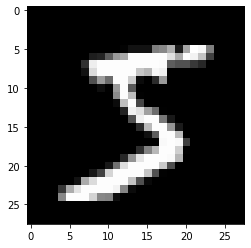

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch 使用torch.tensor而不是 numpy 数组，因此我们需要转换数据。

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

bs = 64  # batch size
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# torch.nn.functional
---------------
用torch.nn.functional（通常按照惯例将其导入到名称空间F中）替换我们的手写激活和损失函数，从而缩短代码长度。 该模块包含torch.nn库中的所有函数（而该库的其他部分包含类）。 除了广泛的损失和激活函数外，您还会在这里找到一些方便的函数来创建神经网络，例如池化函数。 （还有一些用于进行卷积，线性层等的函数，但是正如我们将看到的那样，通常可以使用库的其他部分来更好地处理这些函数。）<br>
如果您使用的是负对数似然损失和对数 softmax 激活，那么 Pytorch 会提供结合了两者的单一函数F.cross_entropy。 因此，我们甚至可以从模型中删除激活函数。

In [5]:
import torch.nn.functional as F

'''
使用torch.nn.functional之前
需要自己定义激活函数：
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
需要自己定义损失函数：
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()
'''

loss_func = F.cross_entropy


# nn.Module和nn.Linear
----------
**1.nn.Module**<br>
我们将nn.Module子类化（它本身是一个类并且能够跟踪状态）。 在这种情况下，我们要创建一个类，该类包含前进步骤的权重，偏置和方法。 nn.Module具有许多我们将要使用的属性和方法（例如.parameters()和.zero_grad()）<br/>
**请注意，nn.Module对象的使用就好像它们是函数一样（即，它们是可调用的），但是在后台 Pytorch 会自动调用我们的forward方法。**
<br>**2.nn.Linear**<br>
使用nn.Linear代替手动定义和初始化`self.weights`和`self.bias`并计算`xb  @ self.weights + self.bias`

In [6]:
from torch import nn

'''
使用nn.Module和nn.Linear之前：
需要自己手动定义和初始化权重和偏置
def model(xb):
    return xb @ weights + bias

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias
'''
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

# 实例化模型
model = Mnist_Logistic()

# torch.optim
---------
Pytorch提供了一个包含各种优化算法的包torch.optim。 我们可以使用优化器中的step方法采取向前的步骤，而不是手动更新每个参数。

In [7]:
'''
使用前，需要手动编码优化步骤，更新网络参数
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

使用后，只需要：
opt.step()
opt.zero_grad()
'''
from torch import optim
# 我们将定义一个小函数来创建模型和优化器，以便将来重用。
lr = 0.5  # 学习率
epochs = 2  # 训练轮数
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3170, grad_fn=<NllLossBackward0>)
tensor(0.0816, grad_fn=<NllLossBackward0>)


# Dataset
-----------
PyTorch 有一个抽象的Dataset类。 数据集可以是具有__len__函数（由 Python 的标准len函数调用）和具有__getitem__函数作为对其进行索引的一种方法。<br>
PyTorch 的TensorDataset是一个数据集包装张量。 通过定义索引的长度和方式，这也为我们提供了沿张量的第一维进行迭代，索引和切片的方法。 这将使我们在训练的同一行中更容易访问自变量和因变量。


In [8]:
from torch.utils.data import TensorDataset

# 将之前的x_train和y_train合并成一个TensorDataset更易于迭代和切片
train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0816, grad_fn=<NllLossBackward0>)


# DataLoader
------
Pytorch 的DataLoader负责批量管理。 您可以从任何Dataset创建一个DataLoader。 DataLoader使迭代迭代变得更加容易。 不必使用`train_ds[i*bs : i*bs+bs]`，DataLoader会自动为我们提供每个小批量。

In [9]:
from torch.utils.data import DataLoader

'''
使用DataLoader之前，需要循环遍历：
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
'''

# 使用DataLoader之后
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()
for epoch in range(epochs):
  for xb, yb in train_dl:
    # 初始化梯度
    opt.zero_grad()
    # 前向传播
    pred = model(xb)
    loss = loss_func(pred, yb)
    # 反向传播
    loss.backward()
    # 参数更新
    opt.step()

print(loss_func(model(xb),yb))

tensor(0.0825, grad_fn=<NllLossBackward0>)


# 使用验证集
在上面的操作中，只是试图建立一个合理的训练循环以用于训练数据。 实际上，应该始终具有验证集，以便识别模型是否过拟合。

对训练数据进行打乱对于防止批量与过拟合之间的相关性很重要。 **另一方面，无论是否打乱验证集，验证损失都是相同的。 由于打乱需要花费更多时间，因此打乱验证数据没有任何意义。**<br>
验证集不需要反向传播，暂用内存少，不需要存储梯度。

In [10]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False)


我们将在每个周期结束时计算并打印验证损失。

**（请注意，我们总是在训练之前调用model.train()，并在推理之前调用model.eval()，因为诸如nn.BatchNorm2d和nn.Dropout之类的层会使用它们，以确保这些不同阶段的行为正确。）**

In [11]:
model, opt = get_model()

for epoch in range(epochs):
  model.train()
  for xb, yb in train_dl:
    # 梯度归零
    opt.zero_grad()

    # 前向传播
    pred = model(xb)
    loss = loss_func(pred, yb)

    # 反向传播
    loss.backward()

    # 参数更新
    opt.step()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
  
  print('{} vaild_loss:{}'.format(epoch, valid_loss / len(valid_dl)))


0 vaild_loss:0.29449668526649475
1 vaild_loss:0.3054908215999603


# CNN
------
我们将使用 Pytorch 的预定义Conv2d类作为我们的卷积层。 我们定义了具有 3 个卷积层的 CNN。 每个卷积后跟一个 ReLU。 最后，我们执行平均池化。 **（请注意，view是 numpy 的reshape的 PyTorch 版本）**

In [14]:
class Mnist_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

  def forward(self, xb):
    xb = xb.veiw(-1, 1, 28, 28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    xb = F.avg_pool2d(xb, 4)
    return xb.view(-1, xb.size(1))

# 学习率
lr = 0.1
model = Mnist_CNN()

# momentum 动量
------
动量是随机梯度下降的一种变体，它也考虑了以前的更新，通常可以加快训练速度。

In [15]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# nn.Sequential
-----
Sequential对象以顺序方式运行其中包含的每个模块。 这是编写神经网络的一种简单方法。

In [17]:
from torch.nn.modules.pooling import AvgPool2d
from torch.nn.modules.activation import ReLU
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4)
)

# 使用GPU训练
-----
如果您足够幸运地能够使用具有 CUDA 功能的 GPU，则可以使用它来加速代码。

In [19]:
# 检查gpu是否可用
print(torch.cuda.is_available())
# 创建一个设备对象
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# 训练前将数据和模型转移至gpu
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

model.to(device)

True
cuda:0


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): AvgPool2d(kernel_size=4, stride=4, padding=0)
)

# 总结
--------
现在，我们有了一个通用的数据管道和训练循环，您可以将其用于使用 Pytorch 训练许多类型的模型。 要了解现在可以轻松进行模型训练，请查看`mnist_sample`示例笔记本。

当然，您需要添加很多内容，例如数据扩充，超参数调整，监控训练，迁移学习等。 这些功能可在 fastai 库中使用，该库是使用本教程中所示的相同设计方法开发的，为希望进一步推广其模型的从业人员提供了自然的下一步。

我们承诺在本教程开始时将通过示例分别说明`torch.nn`，`torch.optim`，`Dataset`和`DataLoader`。 因此，让我们总结一下我们所看到的：

 - `torch.nn`
   + `Module`: 创建一个行为类似于函数的可调用对象，但也可以包含状态（例如神经网络层权重）。 它知道其中包含的 `Parameter` ，并且可以将其所有坡度归零，遍历它们以进行权重更新等。
   + `Parameter`: 张量的包装器，用于告知 Module 具有在反向传播期间需要更新的权重。 仅更新具有`require_grad`属性集的张量
   + `functional`: 一个模块（通常按照惯例导入到 F 名称空间中），其中包含激活函数，损失函数等。 以及卷积和线性层等层的无状态版本。
 - `torch.optim`: 包含诸如 SGD 的优化程序，这些优化程序在后退步骤
 - `Dataset`中更新 `Parameter` 的权重。 具有 `__len__` 和 `__getitem__` 的对象，包括 Pytorch 提供的类，例如 `TensorDataset`
 - ``DataLoader``: 获取任何 Dataset 并创建一个迭代器，该迭代器返回批量数据。